In [4]:
from time import perf_counter

def second_convertion(second: float) -> str:
    """
Convert if seconds > 60 : seconds to hours:minutes:seconds
        Example : (02:23:56)

Convert if seconds < 60 : seconds to {int}{unit}
        Example : (356ms)

    Args:
        second (float): time in second to be converted

    Returns:
        str: return the time from hours to femtoseconds
    """    
    if second < 60:
        power = abs(int(f"{second:.2e}"[-3:])//3)
        return f"""{int(second*1000**power)}{["s", "ms", "μs", "ns", "ps", "fs"][power]}"""
    else:
        m, s = divmod(second, 60)
        h, m = divmod(m, 60)
        return f"""{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}"""

class LoadingBar():
    """
LoadingBar: Create a loading bar inside a loop

with LoadingBar(LENGTH) as bar:
    for i in range(LENGTH):
        bar()
    """
    
    # Print the LoadingBar with all the information
    def __print(self, avancement: int, timeperiter: float, timeremaining: float, timetaken: float, **kwargs: int or float or str):
        string = """[{:,}/{:,}] [{}] [ETR: {}] [TPI: {}] [TT: {}]{}""".format(
            self._iteration,
            self._length,
            str(kwargs)[1:-1].replace("'", " "),
            second_convertion(timeremaining),
            second_convertion(timeperiter),
            second_convertion(timetaken),
            " "*10,
        )
        print(string)
    
    # Update the variable of the LoadingBar
    def next(self, **kwargs):
        """
        Methode used to update the LoadingBar of one iteration
        """
        self._iteration += 1
        avancement = int((self._iteration / self._length)*self._barsize)
        timeperiter = (perf_counter()-self._startime)/self._iteration
        # Update the bar if there is a changement in the 50 little bars 
        # or if an iteration take less than 0.1 seconds
        if avancement > self._oldavancement or timeperiter > 0.01:
            timeremaining = (self._length-self._iteration)*timeperiter
            timetaken = perf_counter()-self._startime
            self._oldavancement = avancement
            self.__print(avancement, timeperiter, timeremaining, timetaken, **kwargs)
    
    def __init__(self, length: int):
        """
        Args:
            length (int): Lenght of the for loop
        """
        self._length: int = length
        self._barsize: int = 50
        self._iteration: int = 0
        self._oldavancement: int = 0
        self._startime: float = perf_counter()
    
    # Variable passed to the with statement : as
    def __enter__(self):
        return self.next
        
    def __exit__(self, exc_type, exc_value, traceback):
        pass

In [5]:
import warnings
warnings.filterwarnings('ignore')

import gzip
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pydot
from IPython.display import display, Image

In [6]:
with gzip.open("sample_data/train-images-idx3-ubyte.gz") as f:
    train_data = np.frombuffer(f.read(), dtype=np.uint8)[16:].reshape(-1,28*28)
with gzip.open("sample_data/train-labels-idx1-ubyte.gz") as f:
    train_labels = np.frombuffer(f.read(), dtype=np.uint8)[8:]
with gzip.open("sample_data/t10k-images-idx3-ubyte.gz") as f:
    test_data = np.frombuffer(f.read(), dtype=np.uint8)[16:].reshape(-1,28*28)
with gzip.open("sample_data/t10k-labels-idx1-ubyte.gz") as f:
    test_labels = np.frombuffer(f.read(), dtype=np.uint8)[8:]
display(f"train_data.shape = {train_data.shape} | train_labels.shape = {train_labels.shape} | test_data.shape = {test_data.shape} | test_labels.shape = {test_labels.shape}")

'train_data.shape = (60000, 784) | train_labels.shape = (60000,) | test_data.shape = (10000, 784) | test_labels.shape = (10000,)'

In [7]:
px.imshow(
    np.concatenate([train_data[0:10].reshape(-1,28,28), test_data[0:10].reshape(-1,28,28)]),
    facet_col=0,
    facet_col_wrap=10,
    labels={"facet_col":"digit_nb"},
)

In [8]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

In [9]:
x_train = min_max_scaler(train_data)
x_test = min_max_scaler(test_data)

In [10]:
def one_hot_encode(x):
    return np.array([(x == uniq_value).astype(float) for uniq_value in np.sort(np.unique(train_labels))]).T

In [11]:
y_train = one_hot_encode(train_labels)
y_test = one_hot_encode(test_labels)

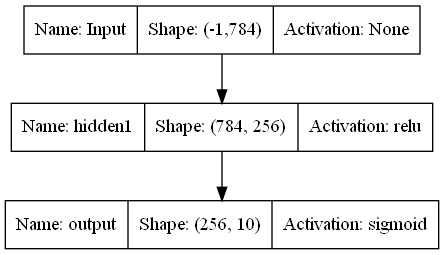

In [12]:
class NeuralNetwork():

    def __init__(self, l: list, *, accuracy_type: str):
        self.accuracy_type = accuracy_type # "binary" or "categorical"
        
        self.activation_refs = {
            "relu": [self.__relu, self.__d_relu],
            "sigmoid": [self.__sigmoid, self.__d_sigmoid],
        }
        self.accuracy_refs = {
            "binary": self.__binary_accuracy,
            "categorical": self.__categorical_accuracy,
        }
        
        self.layers_names: list[str] = [param[0] for param in l[1:]]
        self.layers_activations: list[str] = [param[2] for param in l[1:]]
        
        self.weights: list[list[np.ndarray, np.ndarray]] = [
            [
                np.random.random( (l[i-1][1], l[i][1]) ) *2-1,
                np.zeros(l[i][1])
            ] for i in range(1, len(l))
        ] # [[weight1, bias1], [weight2, bias2], ...]

    def fit(
        self,
        x_data: np.ndarray,
        y_data: np.ndarray,
        *,
        learning_rate: float,
        epoch: int,
        batch_size: int,
        valid_data: tuple = None
    ) -> pd.DataFrame:
        self.learning_rate = learning_rate
        
        accuracy, val_accuracy = [[], []]
        data_size: int = x_data.shape[0]
        with LoadingBar(epoch) as bar:
            for e in range(epoch):
                # Suffle dataset and split it in batchs
                shuffler = np.random.permutation(data_size)
                x_batch = np.split(x_data[shuffler], np.arange(batch_size, data_size, batch_size))
                y_batch = np.split(y_data[shuffler], np.arange(batch_size, data_size, batch_size))
                for x, y in zip(x_batch, y_batch):
                    self.__backward_propagation(
                        self.__forward_propagation(x),
                        y,
                        batch_size,
                    )
                
                accuracy.append(self.accuracy_refs[self.accuracy_type](self.predict(x_data), y_data))
                val_accuracy.append(self.accuracy_refs[self.accuracy_type](self.predict(valid_data[0]), valid_data[1]))
                
                bar(
                    Accuracy = round(accuracy[-1],3),
                    Val_Accuracy = round(val_accuracy[-1],3),
                ) # Update LoadingBar class
                
        return pd.DataFrame(dict(
            epoch = list(range(1,epoch+1)),
            accuracy = accuracy,
            val_accuracy = val_accuracy,
        ))
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        for i in range(len(self.weights)):
            x = (x @ self.weights[i][0]) + self.weights[i][1]
            x = self.activation_refs[self.layers_activations[i]][0](x)
        return x
    
    def summary(self) -> None:
        shapes = [w[0].shape for w in self.weights]

        dot_string = []
        dot_string.append("digraph my_graph {")
        dot_string.append(f"""   node_1 [shape=record label="Name: Input|Shape: (-1,{shapes[0][0]})|Activation: None"];""")
        for i, shape in enumerate(shapes):
            dot_string.append(f"""   node_{i+2} [shape=record label="Name: {self.layers_names[i]}|Shape: {shape}|Activation: {self.layers_activations[i]}"];""")
        dot_string.append("   " + " -- ".join([f"node_{i+1}" for i in range(len(shapes)+1)]))
        dot_string.append("}")
        graphs = pydot.graph_from_dot_data("".join(dot_string))
        display(Image(graphs[0].create_png()))
    
    def __relu(self, x):
        return np.where(x > 0, x, 0)
    
    def __d_relu(self, x):
        return np.where(x > 0, 1, 0)
    
    def __sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def __d_sigmoid(self, x):
        return np.exp(-x)/((1+np.exp(-x))**2)
    
    def __binary_accuracy(self, prediction, y):
        return np.average((prediction >= 0.5) == (y >= 0.5))
    
    def __categorical_accuracy(self, prediction, y):
        return np.average(prediction.argmax(axis=1) == y.argmax(axis=1))
    
    def __forward_propagation(self, x):
        results: list[np.ndarray] = [x]
        for i in range(len(self.weights)):
            results.append( (results[-1] @ self.weights[i][0]) + self.weights[i][1] )
            results.append( self.activation_refs[self.layers_activations[i]][0](results[-1]) )
        return results
            
    def __backward_propagation(self, f_prop, y, batch_size):
        new_weights: list[np.ndarray, np.ndarray] = []
        
        d_errors: np.ndarray = f_prop[-1] - y
        new_weights.append([
            (d_errors.T @ f_prop[-3] / batch_size).T,
            d_errors.sum(axis=0) / batch_size,
        ])
        for i in range(-4, -len(f_prop)-1, -2):
            d_errors = (d_errors @ self.weights[-len(new_weights)][0].T) * self.activation_refs[self.layers_activations[-len(new_weights)-1]][1](f_prop[i])
            new_weights.append([
                (d_errors.T @ f_prop[i-1] / batch_size).T,
                d_errors.sum(axis=0) / batch_size,
            ])
        self.__update_weights(new_weights[::-1])
        
    def __update_weights(self, new_weights):
        for i in range(len(self.weights)):
            self.weights[i][0] -= new_weights[i][0] * self.learning_rate
            self.weights[i][1] -= new_weights[i][1] * self.learning_rate
        
LAYERS = [
    ["input", 784, ""],
    ["hidden1", 256, "relu"],
    ["output", 10, "sigmoid"],
]

model = NeuralNetwork(LAYERS, accuracy_type="categorical")
model.summary()

In [13]:
results = model.fit(
    x_train, y_train,
    learning_rate = 0.01,
    epoch=30,
    batch_size=100,
    valid_data=(
        x_test,
        y_test,
    )
)

[1/30] [ Accuracy : 0.813,  Val_Accuracy : 0.819] [ETR: 58s] [TPI: 2s] [TT: 2s]          
[2/30] [ Accuracy : 0.856,  Val_Accuracy : 0.862] [ETR: 56s] [TPI: 2s] [TT: 4s]          
[3/30] [ Accuracy : 0.875,  Val_Accuracy : 0.882] [ETR: 53s] [TPI: 1s] [TT: 5s]          
[4/30] [ Accuracy : 0.888,  Val_Accuracy : 0.892] [ETR: 52s] [TPI: 2s] [TT: 8s]          
[5/30] [ Accuracy : 0.897,  Val_Accuracy : 0.898] [ETR: 50s] [TPI: 2s] [TT: 10s]          
[6/30] [ Accuracy : 0.903,  Val_Accuracy : 0.904] [ETR: 48s] [TPI: 2s] [TT: 12s]          
[7/30] [ Accuracy : 0.907,  Val_Accuracy : 0.907] [ETR: 46s] [TPI: 2s] [TT: 14s]          
[8/30] [ Accuracy : 0.912,  Val_Accuracy : 0.91] [ETR: 44s] [TPI: 2s] [TT: 16s]          
[9/30] [ Accuracy : 0.916,  Val_Accuracy : 0.914] [ETR: 42s] [TPI: 2s] [TT: 18s]          
[10/30] [ Accuracy : 0.919,  Val_Accuracy : 0.915] [ETR: 39s] [TPI: 1s] [TT: 19s]          
[11/30] [ Accuracy : 0.922,  Val_Accuracy : 0.917] [ETR: 37s] [TPI: 1s] [TT: 21s]          
[1

In [14]:
px.line(results, x="epoch", y=["accuracy", "val_accuracy"])